# Text Extraction

Welcome! This notebook documents the workflow for extracting and validating article-level text from the Parti Pris PDF corpus using the Gemini API.

It includes setup instructions, code examples, and quality control steps.  

## Table of Contents

- [Introduction](#introduction)
- [Corpus](#corpus)
- [Prompting Approach](#prompting-approach)
- [Gemini API Key](#gemini-api-key)
- [Configure Gemini API](#configure-gemini-api)
- [Designing the Prompt for Text Extraction](#designing-the-prompt-for-text-extraction)
- [Discussion](#discussion)
  - [Advantages](#advantages)
  - [Challenges](#challenges)
- [Table of Contents Extraction](#table-of-contents-extraction)
- [Conclusion](#conclusion)
- [Reusability and Broader Applications](#reusability-and-broader-applications)
- [Limitations](#limitations)


## Introduction

The following notebook details Merve Tekgürler's approach to text extraction from the Parti Pris corpus from Summer 2025.

<figure>
    <img src="../img/parti_pris_cover.png"
         alt="Cover of Parti Pris's October 1963 issue">
    <figcaption>Cover of <a href="https://collections.banq.qc.ca/ark:/52327/2314782" target="_blank">Parti Pris' inaugural issue</a> from October 1963.</figcaption>
</figure>

In 2023-2024, Chloé Brault, Clare Chua, and Em Ho compiled the Parti Pris corpus and extracted texts from the same PDFs using ABBYY FineReader. More details about their work can be found [here](https://msuglobaldh.org/abstracts/#brault).

Tekgürler and Brault revisited the project in Summer 2025. This notebook describes how we used Gemini 2.5 API to extract texts from the Parti Pris corpus. It shared the prompting code and offers some insights into the decisions that went into the designing of the prompts as well as safeguards to verify the quality of the OCR output. We 

## Corpus

The complete Parti Pris PDF corpus is approximately 3.48GB in size and includes all 42 issues from the magazine’s entire print run, digitized by the Bibliothèque et Archives Nationales du Québec (BAnQ).

<figure>
    <img src="../img/banq.png"
         alt="Screenshot showing the search page for Parti Pris on the BAnQ website">
    <figcaption>Searching for Parti Pris on the BAnQ website. You can find all the issues of Parti Pris and download the PDFs by following <a href="https://numerique.banq.qc.ca/rechercheExterne/encoded/Kg==/false/D/asc/W3sibm9tIjoiY29ycHVzIiwidmFsZXVyIjoiUGF0cmltb2luZSUyMHF1w6liw6ljb2lzIn0seyJub20iOiJ0eXBlX2RvY19mIiwidmFsZXVyIjoiUmV2dWVzJTIwZXQlMjBqb3VybmF1eCJ9LHsibm9tIjoibnVtZXJvX25vdGljZSIsInZhbGV1ciI6IjAwMDAxNjMxMjIifV0=/Toutes%20les%20ressources/true/false/" target="_blank">this search link</a>. </figcaption>
</figure>

There are three example PDFs in the data folder of this repository (../data/full_pdfs and ../data/split_pdfs), for testing the code in this notebook.

You can adapt this code to your own corpus. There are details in each step describing how and why we made certain decisions. You do not need to run the entire notebook but we would recommend going over it with our data and understanding what the code does before adapting it to your corpora.

This will become more clear when you see the examples but we *strongly urge* you to modify the JSON article schema for Gemini API calls to your corpus. 

Before getting started, don't forget to **install dependencies**  

Run the following in your terminal or a notebook cell:

```python
pip install google-genai python-dotenv pypdf pillow pandas matplotlib seaborn rapidfuzz
```

## Prompting Approach

The previous iteration of this project experimented with OCR'ing entire issues of Parti Pris and then spliting it into small chunks of text for further analysis. This allowed us, for example, to experiment with Named Entity Recognition algorithms to identify places mentioned in this corpus or run word frequency-based analyses to discover trends across the whole corpus. It has however proven to be rather difficult to split the OCR'ed issues into individual articles.

In this new iteration of the project, we revisit our approach to OCR. We use the Gemini 2.5 API to extract text and return a JSON object containing each article as a separate entry.

### Gemini API Key

To prompt Gemini for text extraction, you need to obtain an API key. [This Authentication notebook](https://github.com/google-gemini/cookbook/blob/db5e894d85ccef13cb95d65353407f4ffbcd297c/quickstarts/Authentication.ipynb) shows you how to obtain an API key. If you are new to Gemini or generally accessing LLMs through API calls, [this Getting Started notabook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb) is a great place to start experimenting.

Once you have an API key, create a `.env` file in the root of your repository and add it to `.gitignore`. After pushing the changes to GitHub, spen your `.env` file and type `GEMINI_API_KEY="YOUR_API_KEY"`, where "YOUR_API_KEY" corresponds to the actual key.

In [1]:
# Let's load our API key from the environment
# we will use the python-dotenv package to load the .env file 
# https://pypi.org/project/python-dotenv/

import os
from dotenv import load_dotenv

load_dotenv() # By default load_dotenv will look for the .env file in the current working directory

api_key = os.getenv("GEMINI_API_KEY")

if api_key:
    print("API key loaded successfully.")

API key loaded successfully.


### Configure Gemini API

In [2]:
from google import genai
from google.genai import types

client = genai.Client(api_key=api_key)

In [3]:
# Initialize Gemini 2.5 Flash
MODEL_ID = 'gemini-2.5-flash'

In [4]:
# small test to make sure that the model is working

from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the largest planet in our solar system?"
)

Markdown(response.text)

The largest planet in our solar system is **Jupiter**.

### Designing the Prompt for Text Extraction

The goal of our project is to get high quality and accurate OCR output for each issue of Parti Pris, split by article. We also have some constraints: 

- We are working with PDFs, so we need to upload files with our prompt.
- We want structured output, so JSON generation is our best option.
- We want to control the generation, so we need to understand how the criteria for text extraction that we outline in our prompt impacts the output.
- We need to figure out how the thinking aspect of Gemini 2.5 changes impacts prompting

For further refences, please take a look at Gemini code examples and documentation.
- Document Understanding and Processing: [documentation](https://ai.google.dev/gemini-api/docs/document-processing), [code](https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/document-processing/document_processing.ipynb#scrollTo=Nqwi-5ufWp_B)
- Structured Output and JSON: [documentation](https://ai.google.dev/gemini-api/docs/structured-output), [code](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb#scrollTo=JiIxKaLl4R0f)
- Thinking: [documentation](https://ai.google.dev/gemini-api/docs/thinking)

In [67]:
# 1. Let's upload a PDF file and ask the model to summarize it
# This way we can test the model's ability to handle file uploads

import pathlib

pdf_path = pathlib.Path('../data/full_pdfs/163122_1-1963-10.pdf')

file_upload = client.files.upload(file=pdf_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Can you summarize this file as a bulleted list?",
    ]
)

Markdown(response.text)

This document is the first issue of *Parti Pris*, a political and literary review published in Montreal in October 1963.

Here's a summary of its key contents and philosophy:

*   **Overall Mission & Stance:**
    *   *Parti Pris* aims to be a "political and literary review" that "takes a stance" (*prendre parti*) rather than adopting a detached "objectivity."
    *   It seeks to "demystify" and "create a truth" that transforms Quebec society, viewing analysis and reflection as integral parts of action.
    *   The ultimate goal is to achieve a "free, secular, and socialist State" through a "total revolution."

*   **Analysis of Quebec's Situation ("Notre Perspective"):**
    *   **Alienation:** Quebec is described as a "colonized and exploited" society, suffering from alienation at political, economic, and cultural levels due to external domination (Canadian/American) and internal structures.
    *   **Critique of Previous Generation:** The magazine criticizes older intellectuals (e.g., *Cité Libre*) for their "abstract dialogue" and "objectivity," which failed to address the root causes of alienation and avoided radical change.
    *   **Youth as Revolutionary Force:** The current generation is presented as having moved beyond individual "revolt" (like the "Refus Global" movement) to a collective "revolutionary attitude," understanding societal alienation as a colonial problem.
    *   **The FLQ (Front de libération du Québec):** The arrests of FLQ members are presented as a manifestation of this new, impatient youth, whose violence is seen as a "therapeutic effect" necessary to shake the long-stagnant society and reveal its inherent violence.

*   **Historical & Sociological Context ("Du Duplessisme au F.L.Q."):**
    *   **Legacy of Conquest:** The 1760 conquest led to French Canadians being restricted to religious and cultural spheres, while political and economic control remained with others.
    *   **"Feudal Spirit" & "Agriculturism":** The clerical and traditional elite perpetuated a "feudal spirit" and an "agriculturist" ideology, which, by devaluing industrialization and finance, effectively left the economic field open to foreign capitalists.
    *   **Industrialization & Mass Culture:** Despite the elite's efforts, industrialization and urbanization brought American mass culture, leading to the "assimilation" of Quebecers and exacerbating their economic inferiority and unemployment.
    *   **Political Evolution (1960-1963):** The Liberal victory in 1960 and the nationalization of electricity are seen as positive steps, but the fundamental struggle against Canadian Confederation and foreign economic control continues.

*   **Vision for "Total Revolution" ("Vers une révolution totale"):**
    *   **Comprehensive Change:** A "total revolution" is defined as a radical transformation of the entire life of the people (economy, social structures, politics, culture), going beyond mere political shifts.
    *   **Two Fundamental Contradictions:**
        1.  Canado-American imperialism.
        2.  Private appropriation of national wealth and exploitation of wage labor.
    *   **Solutions:**
        *   **Political Independence:** Essential for Quebec (ideally a "French Republic in America") to gain control over its destiny.
        *   **Economic Socialism:** Nationalization of all significant foreign-controlled enterprises is deemed necessary for genuine economic liberation, a step impossible under capitalism or within the existing Confederation.
        *   **New Democracy:** Emphasizes "people's power" through the conscious participation of the working masses and a "National Unity Government" (Front National et Populaire), moving beyond traditional parliamentary democracy.
    *   **Interconnectedness:** Socialism, popular democracy, and independence are presented as an inseparable trinity.

*   **Cultural & Critical Sections ("Poèmes" & "Chroniques"):**
    *   **Poetry:** Features poems by Paul Chamberland and André Brochu (and André Major) that reflect themes of identity, land, anger, hope, and the struggle for liberation.
    *   **Critique of Information:** The magazine's "Chroniques" section critiques mainstream media for its "mystification" and biased portrayal of the FLQ and separatist movements.
    *   **RIN & FLQ:** Discusses the RIN's (Rassemblement pour l'indépendance nationale) evolution and its eventual acceptance of the FLQ's violent actions as a necessary catalyst for the revolution.
    *   **Cultural Criticism:** Argues that cultural production is directly linked to political and economic realities, and therefore cultural criticism must be revolutionary.
    *   **Abrasive Tone:** The "Vulgarités" section explicitly states its intention to be "vulgar and vengeful" to express animosities and challenges, showcasing the magazine's confrontational style.

The issue lays out a foundational ideology for Quebec's independence movement, intertwining political, economic, and cultural liberation, and positioning *Parti Pris* as a key intellectual driver of this "total revolution."

In [ ]:
print(response)

```python
sdk_http_response=HttpResponse(
  headers=<dict len=11>
) candidates=[Candidate(
  content=Content(
    parts=[
      Part(
        text='[not shown here due to space]'
      ),
    ],
    role='model'
  ),
  finish_reason=<FinishReason.STOP: 'STOP'>,
  index=0
)] create_time=None response_id=None model_version='gemini-2.5-flash' prompt_feedback=None usage_metadata=GenerateContentResponseUsageMetadata(
  candidates_token_count=933,
  prompt_token_count=17040,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=12
    ),
    ModalityTokenCount(
      modality=<MediaModality.DOCUMENT: 'DOCUMENT'>,
      token_count=17028
    ),
  ],
  thoughts_token_count=2753,
  total_token_count=20726
) automatic_function_calling_history=[] parsed=None
```

Based on the information contained in the whole prompt, we can see that the `prompt_token_count` has two modalities: text and document. Text is the part of the prompt that we have written and document is our PDF.

`thoughts_token_count` refers to the thought token that the model used in an internal thinking process.

`candidates_token_count` refers to the output tokens

In [68]:
# Let's print the usage metadata
print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Thoughts tokens:",response.usage_metadata.thoughts_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 17040
Thoughts tokens: 2661
Output tokens: 1092
Total tokens: 20793


- Prompt tokens: 17040
- Thoughts tokens: 2661
- Output tokens: 1092
- Total tokens: 20793

This shows that the model used more than 2.5 times as many thinking tokens as output tokens.

In [ ]:
# 2. Let's upload the same PDF file and ask the model to extract text from it
# At the same time, let's also set a specific thinking budget for the model

pdf_path = pathlib.Path('../data/full_pdfs/163122_1-1963-10.pdf')

file_upload = client.files.upload(file=pdf_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Transcribe the entire PDF. Do not change a word. Make sure to mark the beginnings of each section clearly.",
    ],
    config=types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=1024)
        # Turn off thinking:
        # thinking_config=types.ThinkingConfig(thinking_budget=0)
        # Turn on dynamic thinking:
        # thinking_config=types.ThinkingConfig(thinking_budget=-1)
    ),
)

Markdown(response.text)

In [ ]:
# save response to a file
output_path = pathlib.Path('../data/instructional/1963-10_test1.txt')
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, 'w') as f:
    f.write(response.text)

In [ ]:
# You can see the response by loading it from the saved file
with open('../data/instructional/1963-10_test1.txt', 'r') as f:
    response_text = f.read()
print(response_text)

In [71]:
# Let's see the usage metadata
print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Thoughts tokens:",response.usage_metadata.thoughts_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 17052
Thoughts tokens: 1273
Output tokens: 40650
Total tokens: 58975


Hmm, our output is not that useful. It looks more like the output of an OCR software, which does not produce the same kind of structure that we need. (If you cannot run this test, please instead take a look at the text file at ../data/1963-10_test1.text)

We seem to be on the right track though!

There are two ways to get a model to produce JSON files.

1. Describing a JSON structure in the prompt
2. Creating a JSON schema

This is what a prompt for a JSON structure looks like

```python
prompt = """
Transcribe the entire PDF as accurately as possible, preserving the original words.

Fix only hyphenated words that are split across lines (e.g., “hyphen-\nation” → “hyphenation”).
Preserve paragraph breaks, but remove all line breaks within paragraphs.

This PDF contains multiple articles. For each article, extract and return the following in a JSON format:

    author: the author's name

    title: the article title

    pages: the page range (e.g., "12–15")

    text: the full transcribed text

Return one JSON object with all the articles.
"""
```

This works too, but the JSON schema method turned out to be more reliable, which is what we did for extracting texts below.

In [ ]:
# 3. JSON time! Let's bring in some structure to the response

import json
import typing_extensions as typing

# Define your article schema
class Article(typing.TypedDict):
    author: str
    title: str
    page_range: str
    text: str

pdf_path = pathlib.Path('../data/full_pdfs/163122_1-1963-10.pdf')
json_filename = '../data/instructional/1963-10_test2.json'

# pdf_path = pathlib.Path('/Users/mervetekgurler/Documents/partipris/pdf_corpus/split_pdfs/163122_2-1968-01-B.pdf')
# json_filename = '../data/transcriptions/163122_2-1968-01-B.json'

file_upload = client.files.upload(file=pdf_path)

prompt = """
Transcribe the entire PDF as accurately as possible, preserving the original words.

Fix only hyphenated words that are split across lines (e.g., “entrepri- se” → “entreprise”).
Preserve paragraph breaks, but not line breaks.
This PDF contains multiple articles.
Return ONLY a JSON array of articles, with no extra text or explanation.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[file_upload, prompt],
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[Article],
        'thinking_config': types.ThinkingConfig(thinking_budget=2000)
    },
)

# Parse the JSON string to a Python object
data = json.loads(response.text)

# Save the Python object as JSON
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Thoughts tokens:",response.usage_metadata.thoughts_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 8593
Thoughts tokens: 1463
Output tokens: 18799
Total tokens: 28855


In [ ]:
Markdown(response.text)

Much better! We can clearly see that the model followed the schema. Each article in this issue looks like this:

```python
{
    "author": "Comité de rédaction",
    "title": "présentation",
    "pages": "4-6",
    "text": "Prendre parti, essentiellement, ......."
}
```

Again if you cannot run this code, you can see the output by opening the JSON file (../data/1963-10_test2.json)

In [ ]:
# Let's loop through the PDF corpus and extract the text from each PDF file
# We won't actually run this code, but you can use it as a template for your own corpus

import pathlib
import json
import typing_extensions as typing
import csv
from IPython.display import Markdown
import time

# Define your article schema
class Article(typing.TypedDict):
    author: str
    title: str
    page_range: str
    text: str

# Paths
pdf_folder = pathlib.Path('your_path_here/pdfs')
output_folder = pathlib.Path('your_path_here/gemini_transcriptions')
output_folder.mkdir(exist_ok=True)
csv_path = output_folder / 'transcription_usage.csv'

# Prepare CSV
csv_fields = ['pdf_filename', 'json_filename', 'prompt_tokens', 'thoughts_tokens', 'output_tokens', 'total_tokens', 'note']
if not csv_path.exists():
    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
        writer.writeheader()

# Prompt
prompt = """
Transcribe the entire PDF as accurately as possible, preserving the original words.

Fix only hyphenated words that are split across lines (e.g., “entrepri- se” → “entreprise”).
Preserve paragraph breaks, but not line breaks.
This PDF contains multiple articles.
Return ONLY a JSON array of articles, with no extra text or explanation.
"""

# Loop over PDFs
for pdf_path in pdf_folder.glob('*.pdf'):
    print(pdf_path)
    filename = pdf_path.stem
    json_filename = filename + '.json'
    json_path = output_folder / json_filename

    # Check file size (50MB = 50 * 1024 * 1024 bytes)
    if pdf_path.stat().st_size > 50 * 1024 * 1024:
        # Log skipped file
        info = {
            'pdf_filename': pdf_path.name,
            'json_filename': '',
            'prompt_tokens': '',
            'thoughts_tokens': '',
            'output_tokens': '',
            'total_tokens': '',
            'note': 'SKIPPED: file too large'
        }
        with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
            writer.writerow(info)
        print(f"Skipped (too large): {pdf_path.name}")
        continue

    file_upload = client.files.upload(file=pdf_path)


    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[file_upload, prompt],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[Article],
            'thinking_config': types.ThinkingConfig(thinking_budget=2000)
        },
    )

    # Parse and save JSON
    data = json.loads(response.text)
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    # Gather usage info
    info = {
        'pdf_filename': pdf_path.name,
        'json_filename': json_filename,
        'prompt_tokens': response.usage_metadata.prompt_token_count,
        'thoughts_tokens': response.usage_metadata.thoughts_token_count,
        'output_tokens': response.usage_metadata.candidates_token_count,
        'total_tokens': response.usage_metadata.total_token_count
    }

    # Save to CSV
    with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
        writer.writerow(info)

    # Print info
    print(f"Processed: {json_filename}")
    print(f"Prompt tokens: {info['prompt_tokens']}")
    print(f"Thoughts tokens: {info['thoughts_tokens']}")
    print(f"Output tokens: {info['output_tokens']}")
    print(f"Total tokens: {info['total_tokens']}\n")

    # Wait before next request
    time.sleep(30)

While we won't be able to run the code above, we want to highlight a few things from it

First of all, don't forget to add `time.sleep()` after each API call. We wait 30 seconds between calls which ensures that we won't hit the API limits.

Second, we are creating a CSV and keeping track of three things:
1. Some PDFs are over 50MB, which means that they cannot be processed in API calls. We keep track of this to return to these PDFs later
2. We are saving the usage data, which we will use later for quality control
3. Filenames! We are saving the name of the PDF and the name of the JSON file so that we can always find the correct files through this CSV

Third, we tweaked our prompt. Since the JSON schema is uploaded with the prompt `'response_mime_type': 'application/json'` and `'response_schema': list[Article]`, we do describe the structure in the prompt. Instead we use that space for clarifying some details regarding text extraction.

Four, we save each file right after it is created. This way if something goes wrong, we don't loose hours of work.

## Discussion

### Advantages

There are many advantanges to this approach. We automatically obtain texts split at article level associated with the author of that article as opposed to just with Parti Pris. Parti Pris has relatively standard layout and very few if any images or advertisement. The language is standard mid-century French. Most issues are about 60 pages long, which fits the context window of the model. The scans are in a high resolution. The model can be prompted to perform specific transformations such as making the paragraph breaks but not line breaks and joining hyphenated words back into full words. All this makes text extraction easier.

### Challenges

At the same time there are some challenges inherent in prompting a Large Language Model (LLM) for OCR. These includes issues related to the size of the PDFs and difficulties with verifying the quality and the completeness the outputs. 

**PDF Size**

the PDFs uploaded to the Gemini API cannot be larger than [50MB](https://github.com/googleapis/python-genai/issues/308). We had a total of 42 PDFs in this corpus and 18 of them were over 50MB. Some were only marginally larger, others were combined issues, reaching over 120 pages and 100MB. We could not split the PDFs automatically by size since our goal was to capture each article separately. A size or page number based approach could split up an article in the middle. This meant that we had to either reduce the size of the PDFs and risk reducing the quality of the resolution or split them manually. 

We had a two-part approach. First we transcribed all the PDFs, skipping the ones that were too large and making a note about that in the process. Afterwards we manually split the 18 large PDFs in Adobe Acrobat Pro, creating 42 new PDFs. We retained the filenames, adding '-A', '-B', etc to the end of the filenames. Then we ran a second pass of Gemini 2.5 transcription with the split PDFs.

<figure>
    <img src="../img/large_pdfs.png"
         alt="Screenshot showing the transcription token usage for API calls">
    <figcaption>Transcription token usage after the first pass</figcaption>
</figure>

<figure>
    <img src="../img/second_pass_pdfs.png"
         alt="Screenshot showing the transcription token usage for API calls">
    <figcaption>Transcription token usage after the second pass</figcaption>
</figure>

**Quality and Completeness of the Output**

*Before the API calls*

Best method to check the quality of the output is to read the extracted texts and compare it to what you see on the PDF. We manually checked several examples before proceeding with the API calls. We tweaked our prompting based on these initial experiments. For example, we realized that the model marks line breaks with '\n' which is not necessary for our research and prompted the model to not do that. Please note that marking the end of a line could be very useful if  for example you are working with a manuscript and want to publish a digital edition. You do need to mark the line breaks in that case.

We also realized that the texts contained a lot of hyphenated words at the end of a line. Hyphenation is not common in English but in French, the word at the end of a line is split at the end of the last syllable that fits the line, an hyphen is added to signal this split and the rest of the word continues in the line below. The model tended to keep the hyphens resulting in words like 'enter- prise' instead of merging the word to 'enterprise'. It is not easy to get rid of hyphenation in post-OCR correction because French does make use of the hyphen regularly, for example in the contruction of a question like 'c'est' becomes 'est-ce'. This means that removing - as if it is just puncuation is not ideal. 

Picking up on the smaller, often language and corpus specific details helps design a more effective prompt.

<figure>
    <img src="../img/hyphenation.png"
         alt="Screenshot showing different uses of hyphen">
    <figcaption>Different uses of hyphen marked in red, when it is used for splitting a word at the end of a line and in green for other use cases.</figcaption>
</figure>





*After scaling up*

At a large scale, it is difficult to verify that each PDF has been OCR'ed entirely. Sometimes the model stopped producing text because it ran out of output tokens, particularly if the PDF was really long or if the model was using too many 'thinking' tokens. Sometimes the model added comments, descriptions of images and even translation, creating a much longer output than expected. We retained the token usage for each API call and looked for outliers. 

The easiest way to do that is to create a table of token usage. As you can see in the transcription usage table above, the PDF for June 1966 (163122_2-1966-06.pdf) has only 33 output tokens, which is only a fraction of the output tokens for the April 1966 issue which was 44k tokens long. In this case, this was not a model error but actually this issue does not exist. It has never been published. The PDF scanned by [the BAnQ](https://collections.banq.qc.ca/ark:/52327/2314811) reads "Parti Pris Juin à Août Non paru" (Parti Pris, June to August not published). 

In other instances like in September 1964 (163122_2-1964-09-01.pdf) and December 1964 (163122_2-1964-12-01.pdf), there are additional short pamphlets alongside the main issue. These pamphlets are denotated with '-01' after the date in the PDFs' filenames by the BAnQ. 

While these examples were real cases where the output should have way fewer tokens, this method of checking the output token sizes allowed us to discover inconsistencies in OCR output and rerun the API calls on issues where there was missing texts.

A more in-depth way to check for this is to look at the relationship between the PDF size and the number of output tokens. For that we need to calculate the file sizes of all PDFs.

In [ ]:
# Let's read the CSV file to analyze the transcription usage data
import pandas as pd
df = pd.read_csv("../data/instructional/transcription_usage_fulltext.csv")
df.head()

,pdf_filename,json_filename,prompt_tokens,thoughts_tokens,output_tokens,total_tokens
0,163122_1-1963-10.pdf,163122_1-1963-10.json,17107,1406,34382,52895
1,163122_1-1963-11.pdf,163122_1-1963-11.json,17107,1456,29757,48320
2,163122_1-1963-12.pdf,163122_1-1963-12.json,17107,1986,32445,51538
3,163122_1-1964-01.pdf,163122_1-1964-01.json,17107,1381,38662,57150
4,163122_1-1964-02.pdf,163122_1-1964-02.json,17107,1371,42279,60757


In [ ]:
# Saving the PDF size for better comparison
import os

def get_pdf_size(filename):
    # The PDF corpus is not shared in this repository
    # You need to adjust the path to data if you want to test this code on the 3 example PDFs
    for folder in ["your_path_here/full_pdfs", "your_path_here/split_pdfs"]:
        path = os.path.join(folder, filename)
        if os.path.exists(path):
            size_bytes = os.path.getsize(path)
            return size_bytes / 1_000_000  # size in MB (decimal format)
            #return size_bytes / (1024 * 1024)  # size in MB (binary format)
    return None

df['pdf_size_mb'] = df['pdf_filename'].apply(lambda x: round(get_pdf_size(x), 2))

df[['pdf_filename', 'pdf_size_mb']].head()

,pdf_filename,pdf_size_mb
0,163122_1-1963-10.pdf,36.94
1,163122_1-1963-11.pdf,32.96
2,163122_1-1963-12.pdf,37.85
3,163122_1-1964-01.pdf,35.80
4,163122_1-1964-02.pdf,41.65


In [ ]:
# Save the updated DataFrame to a new CSV file
df.to_csv("../data/instructional/transcription_usage_fulltext_with_size.csv", index=False)

In [ ]:
# If you want to check the size of the PDFs in the corpus, you can run this code
# and load the CSV with PDF size information
df = pd.read_csv("../data/instructional/transcription_usage_fulltext_with_size.csv")

In [45]:
# Calculate the ratio of output tokens to PDF size (tokens per MB)
df['tokens_per_mb'] = df['output_tokens'] / df['pdf_size_mb']

In [46]:
# First, let's check the standard deviation and mean of the tokens per MB

mean_ratio = df['tokens_per_mb'].mean()
std_ratio = df['tokens_per_mb'].std()

print(f"\nAverage tokens per MB: {mean_ratio:.2f}")
print(f"Standard deviation: {std_ratio:.2f}")



Average tokens per MB: 864.61
Standard deviation: 205.84


This shows us that on average each megabyte of our PDFs yields about 865 tokens after OCR/text extraction. Most PDFs will have a tokens-per-MB value within about ±206 of the average (so, roughly between 659 and 1070 tokens per MB). Values much outside this range (e.g., below 659 or above 1070) are more likely to be outliers.

In [47]:
# Then let's identify potential outliers by using the standard deviation method

# Flag as outliers those that are much lower or higher than average (e.g., more than 2 std from mean)
low_outliers = df[df['tokens_per_mb'] < (mean_ratio - 2 * std_ratio)]
high_outliers = df[df['tokens_per_mb'] > (mean_ratio + 2 * std_ratio)]

print("Potential low outliers based on tokens per MB ratio:")
print(low_outliers[['pdf_filename', 'pdf_size_mb', 'output_tokens', 'tokens_per_mb']])

print("\nPotential high outliers based on tokens per MB ratio:")
print(high_outliers[['pdf_filename', 'pdf_size_mb', 'output_tokens', 'tokens_per_mb']])


Potential low outliers based on tokens per MB ratio:
            pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb
38  163122_2-1966-06.pdf         0.58             33      56.896552

Potential high outliers based on tokens per MB ratio:
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb
11  163122_1-1964-09-01.pdf         3.25           5913    1819.384615


We already know about '163122_2-1966-06.pdf' and '163122_1-1964-09-01.pdf'! The former actually does not exist and the latter is a short pamphlet.

A more fine-grained way to check for outlier is to look at the z-score of the tokens per MB.

The **z-score** measures how many standard deviations a value is from the mean of the dataset. For each PDF, the z-score of its tokens-per-MB value tells us whether it is typical (close to 0), unusually low (negative z-score), or unusually high (positive z-score) compared to the rest of the corpus.  
- A z-score near 0 means the value is close to the average.
- A negative z-score (e.g., less than -1.5) indicates a much lower tokens-per-MB ratio than average, which could signal missing content or OCR issues.
- A positive z-score (e.g., greater than 1.5) indicates a much higher tokens-per-MB ratio than average, which could signal duplicated text, OCR artifacts, or unusually dense text.

Using z-scores allows us to systematically flag both low and high outliers for further review.

In [48]:
# One way to check for outliers is to look at the z-score of the tokens per MB
from scipy.stats import zscore
df['tokens_per_mb_z'] = zscore(df['tokens_per_mb'].fillna(0))

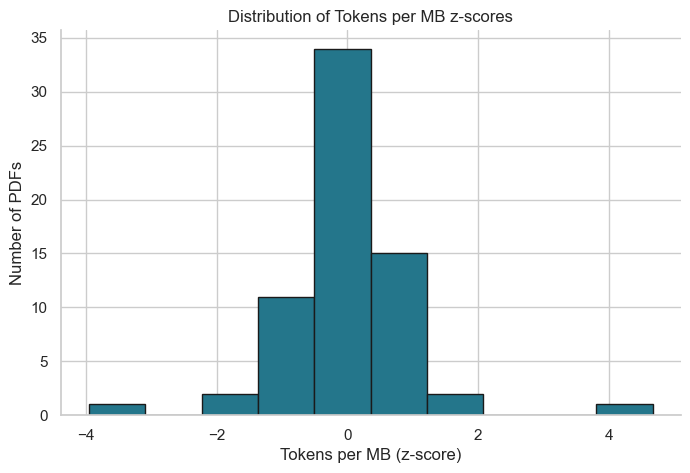

In [49]:
# Let's plot the distribution of tokens per MB z-scores to visualize the outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(
    df['tokens_per_mb_z'].dropna(),
    bins=10,
    color=sns.color_palette("crest", as_cmap=True)(0.6),
    edgecolor='k',
    alpha=1  # Make bars fully opaque
)
plt.xlabel('Tokens per MB (z-score)')
plt.ylabel('Number of PDFs')
plt.title('Distribution of Tokens per MB z-scores')
sns.despine()
#plt.grid(False)
plt.show()

The histogram of tokens per MB z-scores shows how each PDF’s token density compares to the average across the corpus. Most PDFs cluster around a z-score of 0, indicating their tokens-per-megabyte values are close to the mean, which suggests consistent OCR and text extraction quality for the majority of files. 

A few PDFs may fall into the tails of the distribution (z-scores below -1.5 or above 1.5), marking them as potential outliers. Low outliers could indicate missing or incomplete text extraction, while high outliers might suggest unusually dense text, duplicated content, or OCR artifacts. 

Overall, a roughly normal distribution centered near zero with few outliers implies that the extraction process was generally reliable, but the flagged outliers warrant further review to ensure data quality.

In [51]:
# Let's look at the z-score thresholds for outliers
# We can define thresholds for low and high outliers based on z-scores 
# and evaluate the potential outliers

thresholds = [1.5, 1.3, 1, -1, -1.3, -1.5]

for threshold in thresholds:
    if threshold > 0:
        outliers = df[df['tokens_per_mb_z'] > threshold]
        print(f"\nHigh outliers (z > {threshold}): {len(outliers)}")
    else:
        outliers = df[df['tokens_per_mb_z'] < threshold]
        print(f"\nLow outliers (z < {threshold}): {len(outliers)}")
    print(outliers[['pdf_filename', 'pdf_size_mb', 'output_tokens', 'tokens_per_mb', 'tokens_per_mb_z']])


High outliers (z > 1.5): 2
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb  \
9    163122_1-1964-06-B.pdf        37.59          44374    1180.473530   
11  163122_1-1964-09-01.pdf         3.25           5913    1819.384615   

    tokens_per_mb_z  
9          1.546297  
11         4.674061  

High outliers (z > 1.3): 3
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb  \
9    163122_1-1964-06-B.pdf        37.59          44374    1180.473530   
11  163122_1-1964-09-01.pdf         3.25           5913    1819.384615   
12     163122_1-1964-09.pdf        40.92          47752    1166.959922   

    tokens_per_mb_z  
9          1.546297  
11         4.674061  
12         1.480142  

High outliers (z > 1): 6
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb  \
3      163122_1-1964-01.pdf        35.80          38662    1079.944134   
9    163122_1-1964-06-B.pdf        37.59          44374    1180.473530   
11  163122_1-1964-09-0

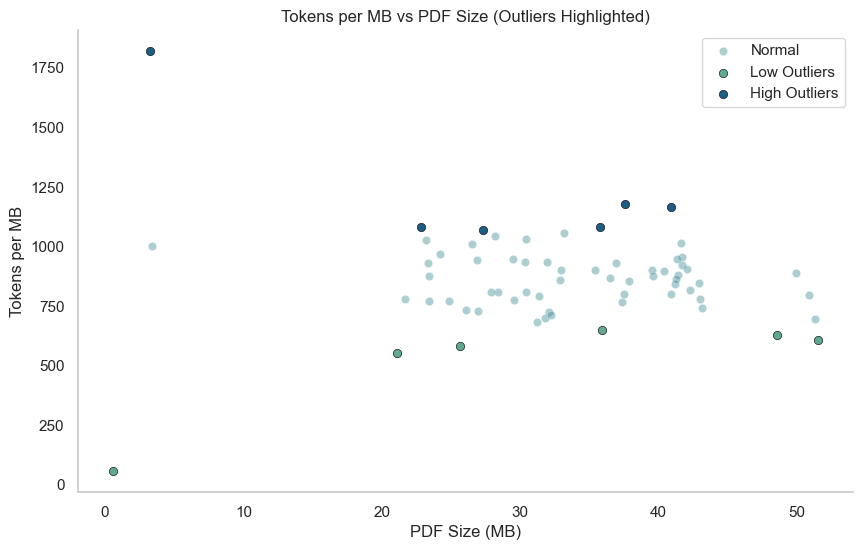

In [56]:
# Another way to visualize the outliers is a scatter plot

low_outliers = df[df['tokens_per_mb_z'] < -1]
high_outliers = df[df['tokens_per_mb_z'] > 1]

plt.figure(figsize=(10, 6))
palette = sns.color_palette("crest", 3)
sns.scatterplot(
    data=df, x='pdf_size_mb', y='tokens_per_mb',
    color=palette[1], alpha=0.4, label='Normal'
)
sns.scatterplot(
    data=low_outliers, x='pdf_size_mb', y='tokens_per_mb',
    color=palette[0], label='Low Outliers', edgecolor='k'
)
sns.scatterplot(
    data=high_outliers, x='pdf_size_mb', y='tokens_per_mb',
    color=palette[2], label='High Outliers', edgecolor='k'
)
plt.xlabel('PDF Size (MB)')
plt.ylabel('Tokens per MB')
plt.title('Tokens per MB vs PDF Size (Outliers Highlighted)')
sns.despine()
plt.legend()
plt.grid(False)
plt.show()

The code identifies outlier PDFs based on their tokens-per-MB z-scores, printing both high and low outliers for several thresholds. 

Let's look at an high outlier: '163122_1-1964-06-B.pdf'

From the pdf filename, we know that this is one of the PDFs that were split manually. Since it is a -B, it is the second part of the PDF. Upon closer investigation, we can see that this PDF is incredibly dense with text. It does not have the title page and the table of contents, which were left in the '163122_1-1964-06-A.pdf'. On top of that, the original 163122_1-1964-06.pdf was split into 3 parts, so the advertisements and subscription information usually at the end of each issue is in the 3rd part '163122_1-1964-06-C.pdf'. This means that '163122_1-1964-06-B.pdf' is just filled with double column text. This is the case for some other high outliers with z-scores larger than 1. They happen to be the middle parts of 3-way split PDFs.

Similarly, in the case of '163122_1-1964-09.pdf' the high z-score is because this is a longer issue with 76 pages (most issues are around 60 pages) but the PDF size is still small due to the scan quality and resolution. 

Let's look at a low outlier: '163122_2-1968-05-C.pdf'

This is the last part of a 3-way split PDF, meaning that the last few pages are devoted to advertisement, which our model is not transcribing. Also, there are more images in the issues from late 1967 and 1968 than in the previous years, including this one. But more importantly this part of the issue is filled with poetry, which takes up a lot more space due to its layout despite having fewer words than continious prose.

This analysis indeed revealed issue with three PDFs: '163122_2-1966-02-A.pdf', 163122_2-1966-09-B.pdf, and 163122_2-1967-09.pdf

All three are missing one or more articles entirely, with 163122_2-1966-09-B.pdf showing signs of degeneration and shuffling of the order of the articles. 163122_2-1967-09.pdf additionally has layout-related problems. This issue is the beginning of a new layout and more image-laden style for Parti Pris. Some of the short snippets between longer articles look like advertisements. There are several full-page images. 

All this shows that looking into outliers is a useful approach to identifying potential issues in a larger dataset. This might not reveal all the problems but being able to identify 3 PDFs with actual important OCR mistakes is rather useful.

## Table of Contents Extraction


One other way to check for completeness is looking at the table of contents for each issue. Luckily, the order of pages remained consistent across the entire print run. The ToC is always on the 3rd page of the PDF. We can automatically extract the 3rd page and extract ToC and metadata.

In [ ]:
# Let's extract the table of contents (ToC) from each PDF file

from pypdf import PdfReader, PdfWriter

input_folder = "your_path_here/pdfs"
output_folder = "your_path_here/toc_pdfs"

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(".pdf"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, f"toc_{filename}")

        reader = PdfReader(input_path)
        writer = PdfWriter()

        # Extract only page 3 (index 2)
        if len(reader.pages) >= 3:
            writer.add_page(reader.pages[2])

            with open(output_path, "wb") as out_file:
                writer.write(out_file)

Before the next steps, we removed 3 PDFs. As we discusses above the June 1966 (163122_2-1966-06.pdf) issue does not exist and the 163122_1-1964-12-01.pdf is an overview of the year and 163122_1-1964-09-01.pdf is a short pamphlet.

We carefully studied the ToC and metadata to understand its structure and translate it into the JSON schema.

<div style="display: flex; gap: 20px;">
  <img src="../img/toc_early_issues.png" alt="ToC example from an earlier issue" width="45%">
  <img src="../img/toc_later_issues.png" alt="ToC example from a later issue" width="45%">
</div>

In [ ]:
# We use the same approach as the text extraction code to extract the ToC from each PDF file
# again this code won't run here, but you can use it as a template for your own corpus

import pathlib
import json
import typing_extensions as typing
import csv
from IPython.display import Markdown
import time

class TOCMetadata(typing.TypedDict):
    volume_number: str                # e.g., "vol. 5"
    issue_number: str                 # e.g., "nos 2-3"
    season_or_month: str              # e.g., "été or oct.-nov."
    year: str                         # e.g., "1967"
    director: str                     # e.g., "philippe bernard"
    description: str                  # e.g., "revue politique et culturelle"
    price: str                        # e.g., "75¢", "$6.00"
    editors: list[str]                # e.g., ["philippe bernard", "gilles bourque", ...]
    collaborators: list[str]          # e.g., ["jacques allard", "denis arcand", ...]
    administration: list[str]         # e.g., ["gilles bourque", "gilles dostaler", ...]
    publisher: str                    # e.g., "La revue PARTI PRIS, inc."
    distributor: str                  # e.g., "agence de distribution populaire, 1130 Lagauchetière est, Montréal"

class TOCEntry(typing.TypedDict):
    section: str                       # e.g., "CHRONIQUES" or ""
    title: str                         # e.g., "le quèbec en mots dit"
    authors: list[str]                 # e.g., ["gilles dostaler", "gaston miron", ...]
    page: str                          # e.g., "3"

class TOCExtraction(typing.TypedDict):
    metadata: TOCMetadata
    toc: list[TOCEntry]

pdf_folder = pathlib.Path('your_path_here/toc_pdfs')
output_folder = pathlib.Path('your_path_here/toc_transcriptions')
output_folder.mkdir(exist_ok=True)
csv_path = output_folder / 'transcription_usage.csv'

csv_fields = ['pdf_filename', 'json_filename', 'prompt_tokens', 'thoughts_tokens', 'output_tokens', 'total_tokens', 'note']

# Read already processed PDFs from CSV
processed_pdfs = set()
if csv_path.exists():
    with open(csv_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['json_filename']:  # Only consider as processed if JSON was created
                processed_pdfs.add(row['pdf_filename'])

prompt = """
You are an expert in French language journals. 
You will extract the metadata and the table of contents from a journal from the 1960s. 
Transcribe it as accurately as possible, keeping the original words.
If a field is missing, use an empty string or empty list.
Prioritize title and authors in the ToC entries.

Return ONLY the JSON object, with no extra text or explanation.
"""

for pdf_path in pdf_folder.glob('*.pdf'):
    if pdf_path.name in processed_pdfs:
        print(f"Already processed: {pdf_path.name}")
        continue

    filename = pdf_path.stem
    json_filename = filename + '.json'
    json_path = output_folder / json_filename

    try:
        file_upload = client.files.upload(file=pdf_path)
        response = client.models.generate_content(
            model=MODEL_ID,
            contents=[file_upload, prompt],
            config={
                'response_mime_type': 'application/json',
                'response_schema': TOCExtraction,
                'thinking_config': types.ThinkingConfig(thinking_budget=3000)
            },
        )

        if response.text is None:
            raise ValueError("API returned no text.")

        data = json.loads(response.text)
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

        info = {
            'pdf_filename': pdf_path.name,
            'json_filename': json_filename,
            'prompt_tokens': response.usage_metadata.prompt_token_count,
            'thoughts_tokens': response.usage_metadata.thoughts_token_count,
            'output_tokens': response.usage_metadata.candidates_token_count,
            'total_tokens': response.usage_metadata.total_token_count,
            'note': ''
        }

        write_header = not csv_path.exists()
        with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
            if write_header:
                writer.writeheader()
            writer.writerow(info)

        print(f"Processed: {json_filename}")
        print(f"Prompt tokens: {info['prompt_tokens']}")
        print(f"Thoughts tokens: {info['thoughts_tokens']}")
        print(f"Output tokens: {info['output_tokens']}")
        print(f"Total tokens: {info['total_tokens']}\n")

        time.sleep(10)

    except Exception as e:
        print(f"Error processing {pdf_path.name}: {e}")
        info = {
            'pdf_filename': pdf_path.name,
            'json_filename': '',
            'prompt_tokens': '',
            'thoughts_tokens': '',
            'output_tokens': '',
            'total_tokens': '',
            'note': f'ERROR: {e}'
        }
        write_header = not csv_path.exists()
        with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
            if write_header:
                writer.writeheader()
            writer.writerow(info)
        continue

In [8]:
# The ToC transcriptions are saved in the data folder
# Let's load one and take a look at it

toc_example_path = '../data/toc_transcriptions/toc_163122_1-1963-10.json'
with open(toc_example_path, 'r', encoding='utf-8') as f:
    toc_example = json.load(f)

#print(toc_example)
articles_toc = toc_example['toc']
titles_toc = [article['title'] for article in articles_toc]
titles_toc

['présentation',
 'de la révolte à la révolution',
 'du duplessisme au F.L.Q.',
 'vers une révolution totale',
 "poème de l'antérévolution",
 'un enfant du pays',
 'blancheur de moi-même',
 "salutations d'usage",
 "chronique d'une révolution",
 'chronique du R.I.N.',
 'les divertissements',
 'paul morin',
 'pour riches seulement',
 "chronique de l'éducation",
 'vulgarités']

Neat! We can now compare the article titles and authors from the ToC and the full text extraction of the same issue

In [9]:
# Now with the full text file

with open("../data/transcriptions/163122_1-1963-10.json", "r", encoding="utf-8") as f:
    articles_fulltext = json.load(f)

titles_fulltext = [article["title"] for article in articles_fulltext]
titles_fulltext

['Présentation',
 'De la révolte à la révolution',
 'Du duplessisme au F.L.Q.',
 'Vers une révolution totale',
 "Poème de l'antérévolution",
 'Un enfant du pays',
 'Blancheur de moi-même',
 "Salutations d'usage",
 "Chronique d'une révolution",
 'Chronique du R.I.N.',
 'Les divertissements',
 'Paul Morin',
 'Pour riches seulement',
 "Chronique de l'éducation",
 'Vulgarités']

The first issue seems fine to me! We can scale this up to the entire corpus to see if and where have missing articles.

In [17]:
# Let's count the number of articles in the ToC and in the full text

import os
import json
import pandas as pd

toc_dir = "../data/toc_transcriptions"
fulltext_dir = "../data/instructional/transcriptions_for_toc_comparison" 

# We do not include the "163122_1-1964-09-01.json" and "163122_1-1964-12-01.json"
# "163122_2-1966-06.json" is empty
skip_files = {
    "163122_1-1964-09-01.json",
    "163122_1-1964-12-01.json",
    "163122_2-1966-06.json"
}

count_results = []

for toc_file in os.listdir(toc_dir):
    if not toc_file.endswith(".json"):
        continue
    base_issue = toc_file.replace("toc_", "")
    if base_issue in skip_files:
        continue
    toc_path = os.path.join(toc_dir, toc_file)
    prefix = base_issue.replace(".json", "")

    # Use all matching files from fulltext_dir (split parts, if any)
    fulltext_files = [
        os.path.join(fulltext_dir, f)
        for f in os.listdir(fulltext_dir)
        if f.startswith(prefix) and f.endswith(".json") and f not in skip_files
    ]
    if not fulltext_files:
        print(f"Warning: {base_issue} not found in fulltext_dir.")
        continue

    # Load ToC
    with open(toc_path, "r", encoding="utf-8") as f:
        toc_data = json.load(f)
        toc_count = len(toc_data["toc"])

    # Load and merge fulltext articles
    merged_articles = []
    for path in sorted(fulltext_files):
        with open(path, "r", encoding="utf-8") as f:
            merged_articles.extend(json.load(f))
    fulltext_count = len(merged_articles)

    count_results.append({
        "issue": base_issue,
        "toc_count": toc_count,
        "fulltext_count": fulltext_count,
        "count_diff": toc_count - fulltext_count
    })

df_counts = pd.DataFrame(count_results)
df_counts["abs_diff"] = df_counts["count_diff"].abs()
df_counts_sorted = df_counts.sort_values("abs_diff", ascending=False)
print(df_counts_sorted[["issue", "toc_count", "fulltext_count", "abs_diff"]])

                    issue  toc_count  fulltext_count  abs_diff
24  163122_2-1968-05.json         16              50        34
7   163122_2-1968-01.json         12              30        18
17  163122_2-1967-01.json         15              30        15
10  163122_2-1966-02.json         12              27        15
22  163122_1-1965-08.json         15              28        13
35  163122_2-1967-10.json         12              25        13
0   163122_2-1967-09.json         11              24        13
20  163122_1-1965-12.json         11              23        12
9   163122_1-1965-10.json         12              23        11
8   163122_2-1966-09.json         14              24        10
13  163122_2-1967-03.json         15              25        10
3   163122_2-1967-05.json         19              28         9
33  163122_2-1966-11.json         15              22         7
6   163122_2-1966-05.json         13              19         6
36  163122_1-1964-02.json         13              19   

In [18]:
# Analyze and summarize count differences between ToC and fulltext

# Count how many issues have zero difference
zero_diff = df_counts_sorted[df_counts_sorted["count_diff"] == 0]
num_zero_diff = len(zero_diff)

# More articles listed in ToC than extracted in fulltext
toc_missing = df_counts_sorted[df_counts_sorted["count_diff"] > 0]
num_toc_missing = len(toc_missing)

# More articles extracted in fulltext than listed in ToC
fulltext_extra = df_counts_sorted[df_counts_sorted["count_diff"] < 0]
num_fulltext_extra = len(fulltext_extra)

print(f"Number of issues with no difference: {num_zero_diff}")
print(f"Number of issues with missing articles in fulltext: {num_toc_missing}")
print(f"Number of issues with extra articles in fulltext: {num_fulltext_extra}\n")

print("Issues with missing articles in fulltext:")
print(toc_missing[["issue", "toc_count", "fulltext_count", "count_diff"]].to_string(index=False))

print("\nIssues with extra articles in fulltext:")
print(fulltext_extra[["issue", "toc_count", "fulltext_count", "count_diff"]].to_string(index=False))

Number of issues with no difference: 16
Number of issues with missing articles in fulltext: 2
Number of issues with extra articles in fulltext: 21

Issues with missing articles in fulltext:
                issue  toc_count  fulltext_count  count_diff
163122_2-1966-03.json         10               9           1
163122_1-1964-03.json         14              13           1

Issues with extra articles in fulltext:
                issue  toc_count  fulltext_count  count_diff
163122_2-1968-05.json         16              50         -34
163122_2-1968-01.json         12              30         -18
163122_2-1967-01.json         15              30         -15
163122_2-1966-02.json         12              27         -15
163122_1-1965-08.json         15              28         -13
163122_2-1967-10.json         12              25         -13
163122_2-1967-09.json         11              24         -13
163122_1-1965-12.json         11              23         -12
163122_1-1965-10.json         12     

Just visualizing the counts showed that out of the 39 PDFs, 16 were fully matched. 5 issues show minimal differences (1-2 articles extra or missing). 28 articles have differences larger than 3 articles, with 163122_2-1968-05.json having 34 articles more than the ToC.

> Note: I was doubting the usefulness of this but when I ran this code for the first time, I realized that one of the split PDFs (1965-01-A) was missing in transcriptions. The transcription was created, hence it had the metadata but it was not saved, possibly due to some save issue. I fixed that before this write-up.

Let's investigate further!

First, let's look at the ones where there were articles missing in the full text but listed in the ToC: 163122_2-1966-03.json and 163122_1-1964-03.json. We will investigate them manually.

163122_2-1964-03.json in the ToC has an entry titled "notes sur l'information" on page 44. In the fulltext this information is available but it is not marked differently.

163122_2-1966-03.json is indeed missing a section. The last part, "marginales" was not transcribed. We fixed this by re-running the OCR.


In [26]:
# Let's read the ToC of 163122_2-1968-05.json
toc_path = "../data/toc_transcriptions/toc_163122_2-1968-05.json"
with open(toc_path, "r", encoding="utf-8") as f:
    toc_data = json.load(f)

print("Metadata:")
for key, value in toc_data["metadata"].items():
    print(f"{key}: {value}")
print("\nTable of Contents:")
for idx, entry in enumerate(toc_data["toc"], 1):
    print(f" {idx:2d}. {entry['section']}: {entry['title']} ({', '.join(entry['authors'])}) - Page {entry['page']}")
    # print(f" {idx:2d}. {entry['title']}")

Metadata:
volume_number: 5
issue_number: 8-9
season_or_month: été
year: 1968
director: philippe bernard
description: revue politique et culturelle paraît tous les mois sur 60 pages
price: 75¢
editors: ['gilles bourque', 'jan depocas', 'gilles dostaler', 'gabriel gagnon', 'pierre maheu', 'luc racine', 'robert tremblay']
collaborators: ['jacques allard', 'denis arcand', 'rené beaudin', 'jacques brault', 'andré brochu', 'paul chamberland', 'pierre desrosiers', 'raoul duguay', 'jacques ferron', 'charles gagnon', 'roger guy', 'robert maheu', 'gaston miron', 'michel pichette', 'jean-marc piotte', 'narcisso pizarro', 'jacques poisson', 'jean-robert rémillard', 'pierre renaud', 'patrick straram', 'andré théberge', 'gaétan tremblay', 'pierre vadeboncoeur', 'pierre vallières']
administration: ['jean-claude robert', 'huguette corbo', 'marc laliberté']
publisher: Parti Pris
distributor: agence de distribution populaire

Table of Contents:
  1. éditorial: éditorial () - Page 3
  2. québec politique

For comparison, here is a screenshot of the table of contents from the May 1968 issue.

![img](../img/toc_1968_05.png)

It seems like the ToC extraction was accurate. There are some issues with section and title in the first 4 articles after the editorial. For example the first section is "québec politique" and it contains 2 articles, one by Dostaler and another by Gagnon. Their titles are however not in the ToC. The model put the name of the author as the title, which is following what we asked for in the ToC prompt: "Prioritize title and authors in the ToC entries." 

This also means that the changes in the style of Parti Pris, i.e. not including the full title of each article in a section, might be effecting our results. Particularly, let's look at "québec '68: forum-débat". It is 27 pages long, has no author or article titles. 

In [ ]:
# Let's read the titles, authors, and pages from the fulltext
# This is a split issue, so we need to load all 3 parts
fulltext_parts = [
    "163122_2-1968-05-A.json",
    "163122_2-1968-05-B.json",
    "163122_2-1968-05-C.json"
]
fulltext_articles = []
for part in fulltext_parts:
    with open(f"../data/instructional/transcriptions_for_toc_comparison/{part}", "r", encoding="utf-8") as f:
        part_data = json.load(f)
        fulltext_articles.extend(part_data)

titles_fulltext = [article["title"] for article in fulltext_articles]
authors_fulltext = [article["author"] for article in fulltext_articles]
pages_fulltext = [article["page_range"] for article in fulltext_articles]
print("\nFulltext Articles:")
for idx, (title, authors, pages) in enumerate(zip(titles_fulltext, authors_fulltext, pages_fulltext), 1):
    print(f" {idx:2d}. {title} ({authors}) - Pages {pages}")


Fulltext Articles:
  1. la contestation étudiante (Philippe Bernard) - Pages 5-8
  2. nègres blancs d'amérique (Gilles Dostaler) - Pages 10-11
  3. rené lévesque n'est pas lumumba! (Charles Gagnon) - Pages 11-12
  4. le M.S.A. à droite ou à gauche? (Jean-Guy Loranger) - Pages 12-14
  5. galbraith:: prophète ou fumiste? (Gabriel Gagnon) - Pages 14-15
  6. l'avenir du syndicalisme québécois ou quand le C.T.C. fait l'autruche (Gabriel Gagnon) - Pages 16-17
  7. révolution culturelle en tchécoslovaquie (Philippe Bernard) - Pages 17-18
  8. black power: rejoindre la révolution noire mondiale (Gilles Dostaler) - Pages 18-21
  9. présentation (Philippe Bernard) - Pages 23-37
 10. françois aquin: il n'y a pas d'ersatz de la liberté - propos recueilli par jan depocas (Jan Depocas) - Pages 48-56
 11. les étudiants et la question nationale (Ronald Sabourin) - Pages 57-64
 12. a la santé de rudi dutschke et quelques autres folk-rock mirabellenwasser (Patrick Straram) - Pages 65-73
 13. le québec 

Well, this is interesting! It seems like there are some repeating articles. Look at the articles 10 through 17, also copied below.

- 10. françois aquin: il n'y a pas d'ersatz de la liberté - propos recueilli par jan depocas (Jan Depocas)- Pages 48-56
- 11. les étudiants et la question nationale (Ronald Sabourin) - Pages 57-64
- 12. a la santé de rudi dutschke et quelques autres folk-rock mirabellenwasser (Patrick Straram) - Pages 65-73
- 13. le québec en mots dit (Pierre Maheu) - Pages 74-74
- 14. la poésie en 1968: quelques réflexions (Gérald Godin) - Pages 75-75
- 15. objecteur de conscience (Raymond Lévesque) - Pages 76-77
- 16. poèmes inédits (Gaston Miron) - Pages 78-78
- 17. trois mois après (André Théberge) - Pages 79-80

These are all from 163122_2-1968-05-A.json. Having split the PDFs manually, we know for a fact that the A split did not contain any articles beyond the beginning of the "québec '68", which in the full text version starts with a piece titled "présentation" by Philippe Bernard. However, this same PDF also contained the ToC, so Gemini had seen what the next articles would be and without the full text available, it hallucinated them.

We missed this hallucination in our token/MB analysis because the output had tokens 36268 and the PDF waw 40.4MB, leading to a 897.72 tokens per MB, which is well within our acceptable range (Average tokens per MB: 864.61 and Standard deviation: 205.84). 

We will obviously rerun the text extraction on this issue but before that let's see how **Gemini rendered Gaston Miron's poetry**:

In [ ]:
import re

with open("../data/instructional/transcriptions_for_toc_comparison/163122_2-1968-05-A.json", "r", encoding="utf-8") as f:
    articles = json.load(f)
gemini_article = next(article["text"] for article in articles if article["title"] == "poèmes inédits")
lines = re.split(r' (?=[A-ZÉÈÀÂÎÔÛÇ])', gemini_article)
for line in lines[:16]:
    print(line.strip())

La nuit
La nuit est un mystère
Un voile sur le monde
Un silence lourd et profond
Un rêve qui s'envole
Un secret bien gardé
Une énigme à percer
Un chemin inconnu
Une porte vers l'ailleurs
Un miroir de l'âme
Une étreinte douce et chaude
Un baiser volé
Une caresse légère
Un souffle de vent
Un murmure lointain
Une mélodie oubliée


In [19]:
# After updating 1968-05 and 1966-03, let's check everything again

import os
import json
import pandas as pd

toc_dir = "../data/toc_transcriptions"
fulltext_dir = "../data/transcriptions"

# We do not include the "163122_1-1964-09-01.json" and "163122_1-1964-12-01.json"
# "163122_2-1966-06.json" is empty
skip_files = {
    "163122_1-1964-09-01.json",
    "163122_1-1964-12-01.json",
    "163122_2-1966-06.json"
}

# Only use files in fulltext_dir, skipping the ones above
all_fulltext_files = [
    f for f in os.listdir(fulltext_dir)
    if f.endswith(".json") and f not in skip_files
]

count_results = []

for toc_file in os.listdir(toc_dir):
    if not toc_file.endswith(".json"):
        continue
    base_issue = toc_file.replace("toc_", "")
    if base_issue in skip_files:
        continue
    toc_path = os.path.join(toc_dir, toc_file)
    prefix = base_issue.replace(".json", "")
    # Only use filtered fulltext files (skip files already removed)
    fulltext_parts = [
        f for f in all_fulltext_files if f.startswith(prefix)
    ]
    if not fulltext_parts:
        continue
    # Load ToC
    with open(toc_path, "r", encoding="utf-8") as f:
        toc_data = json.load(f)
        toc_count = len(toc_data["toc"])
    # Load and merge fulltext articles
    merged_articles = []
    for part_file in sorted(fulltext_parts):
        with open(os.path.join(fulltext_dir, part_file), "r", encoding="utf-8") as f:
            merged_articles.extend(json.load(f))
    fulltext_count = len(merged_articles)
    count_results.append({
        "issue": base_issue,
        "toc_count": toc_count,
        "fulltext_count": fulltext_count,
        "count_diff": toc_count - fulltext_count
    })

df_counts = pd.DataFrame(count_results)
df_counts["abs_diff"] = df_counts["count_diff"].abs()
df_counts_sorted = df_counts.sort_values("abs_diff", ascending=False)
print(df_counts_sorted[["issue", "toc_count", "fulltext_count", "abs_diff"]])


                    issue  toc_count  fulltext_count  abs_diff
24  163122_2-1968-05.json         16              43        27
17  163122_2-1967-01.json         15              30        15
7   163122_2-1968-01.json         12              27        15
10  163122_2-1966-02.json         12              27        15
35  163122_2-1967-10.json         12              25        13
22  163122_1-1965-08.json         15              28        13
0   163122_2-1967-09.json         11              24        13
20  163122_1-1965-12.json         11              23        12
9   163122_1-1965-10.json         12              23        11
8   163122_2-1966-09.json         14              24        10
13  163122_2-1967-03.json         15              25        10
3   163122_2-1967-05.json         19              28         9
33  163122_2-1966-11.json         15              22         7
6   163122_2-1966-05.json         13              19         6
36  163122_1-1964-02.json         13              19   

We still have a large difference with 163122_2-1968-05.

In [46]:
# Let's read the titles, authors, and pages from the fulltext
# This is a split issue, so we need to load all 3 parts
fulltext_parts = [
    "163122_2-1968-05-A.json",
    "163122_2-1968-05-B.json",
    "163122_2-1968-05-C.json"
]
fulltext_articles = []
for part in fulltext_parts:
    with open(f"../data/transcriptions/{part}", "r", encoding="utf-8") as f:
        part_data = json.load(f)
        fulltext_articles.extend(part_data)

titles_fulltext = [article["title"] for article in fulltext_articles]
authors_fulltext = [article["author"] for article in fulltext_articles]
pages_fulltext = [article["page_range"] for article in fulltext_articles]
print("\nFulltext Articles:")
for idx, (title, authors, pages) in enumerate(zip(titles_fulltext, authors_fulltext, pages_fulltext), 1):
    print(f" {idx:2d}. {title} ({authors}) - Pages {pages}")


Fulltext Articles:
  1. la contestation étudiante (philippe bernard) - Pages 5-8
  2. nègres blancs d'amérique (gilles dostaler) - Pages 10-11
  3. rené lévesque n'est pas lumumba! (charles gagnon) - Pages 11
  4. le M.S.A. à droite ou à gauche? (jean-guy loranger) - Pages 12-14
  5. galbraith:: prophète ou fumiste? (gabriel gagnon) - Pages 12-16
  6. révolution culturelle en tchécoslovaquie (philippe bernard) - Pages 15-16
  7. black power: rejoindre la révolution noire mondiale (gilles dostaler) - Pages 16-21
  8. présentation (philippe bernard) - Pages 23-26
  9. M.S.A. et SOCIALISME (gabriel gagnon) - Pages 27
 10. QUÉBEC LAÏQUE où QUÉBEC YANKEE? (pierre maheu) - Pages 28-35
 11. pour un mouvement socialiste et indépendantiste (robert tremblay) - Pages 31-37
 12. étudiant (jean-marc piotte) - Pages 37-38
 13. étudiant le M.S.A. et l'ambiguïté de la gauche (gaétan tremblay) - Pages 39-40
 14. question 1 (un fonctionnaire (québec)) - Pages 40-41
 15. questions en réponse à des quest

After redoing -A, there does not seem to be any hallucinations and the issue now is about the "québec '68: forum-débat". In the ToC, it appears as one entry. In the fulltext, it consists of 23 smaller entries, 8 though 30 (included). Same goes for "françois aquin", which is an interview with several subheadings, each subheading is transcribed as a separate article in the full text. This means that 1 entry in the ToC becomes 5 entries in the fulltext.

This is of course not ideal but we can fix this in the post!

163122_2-1968-01-A.json has the same issue, but instead of hallucinating, the model produced some comments: "This article is listed in the table of contents (p. 35) but the provided images end at page 30. This indicates the article itself is not present in the provided page range."

Let's update 1968-01-A and 1968-01-B too!

Finally, let's take a look at the rest of the issues where we identified large differences. We can compare the titles and the authors so that we can get a quick overview of the differences at scale.

In [20]:
# Let's get a copy of the df_counts_sorted DataFrame and remove the entries with zero difference
# and the issue "163122_2-1968-05.json" which we have already discussed
# 163122_1-1964-03.json has a mismatch of 1 but it is because the toc has notes listed as an entry

df_counts_filtered = df_counts_sorted.copy()
df_counts_filtered = df_counts_filtered[
    (df_counts_filtered["abs_diff"] != 0) &
    (df_counts_filtered["issue"] != "163122_2-1968-05.json") &
    (df_counts_filtered["issue"] != "163122_1-1964-03.json")
]
df_counts_filtered.reset_index(drop=True, inplace=True)
df_counts_filtered

,issue,toc_count,fulltext_count,count_diff,abs_diff
0,163122_2-1967-01.json,15,30,-15,15
1,163122_2-1968-01.json,12,27,-15,15
2,163122_2-1966-02.json,12,27,-15,15
3,163122_2-1967-10.json,12,25,-13,13
4,163122_1-1965-08.json,15,28,-13,13
5,163122_2-1967-09.json,11,24,-13,13
6,163122_1-1965-12.json,11,23,-12,12
7,163122_1-1965-10.json,12,23,-11,11
8,163122_2-1966-09.json,14,24,-10,10
9,163122_2-1967-03.json,15,25,-10,10


In [43]:
import pandas as pd
from rapidfuzz import process, fuzz
import unicodedata
import re
import string

def normalize_text(text):
    text = text or ""
    text = text.strip().lower()
    text = unicodedata.normalize("NFKD", text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # remove all punctuation
    text = re.sub(r"\s+", " ", text)
    text = text.replace("–", "-").replace("—", "-")
    text = text.replace("“", "\"").replace("”", "\"").replace("’", "'")
    return text.strip()

def map_toc_to_fulltext(toc_entries, fulltext_entries, threshold=80, author_threshold=85):
    mapping = []
    fulltext_titles_norm = [normalize_text(entry["title"]) for entry in fulltext_entries]
    fulltext_authors_norm = [normalize_text(entry.get("author", "")) for entry in fulltext_entries]
    used_fulltext_indices = set()
    last_matched_idx = -1

    for toc_idx, toc_entry in enumerate(toc_entries):
        # Always use title if present, otherwise use section as the title
        toc_title_val = toc_entry.get("title", "") or toc_entry.get("section", "")
        toc_title_norm = normalize_text(toc_title_val)
        toc_authors_norm = [normalize_text(a) for a in toc_entry.get("authors", [])]

        # Title match: only unused entries
        candidates = [(i, t) for i, t in enumerate(fulltext_titles_norm) if i not in used_fulltext_indices]
        if candidates:
            idxs, titles = zip(*candidates)
            match, score, rel_idx = process.extractOne(
                toc_title_norm, titles, scorer=fuzz.token_sort_ratio
            )
            idx = idxs[rel_idx]
        else:
            score = 0
            idx = None

        if score >= threshold and idx is not None:
            mapping.append({
                "toc_title": toc_title_val,
                "toc_authors": ", ".join(toc_entry.get("authors", [])),
                "best_fulltext_title": fulltext_entries[idx]["title"],
                "fulltext_authors": fulltext_entries[idx]["author"],
                "score": score,
                "match_type": "title",
                "status": "matched"
            })
            used_fulltext_indices.add(idx)
            last_matched_idx = max(last_matched_idx, idx)
        else:
            # Author match: only unused entries after last_matched_idx
            best_author_score = 0
            best_idx = None
            for i, fauth in enumerate(fulltext_authors_norm):
                if i in used_fulltext_indices or i < last_matched_idx:
                    continue
                for tauth in toc_authors_norm:
                    if tauth and fauth:
                        this_score = fuzz.token_sort_ratio(tauth, fauth)
                        if this_score > best_author_score:
                            best_author_score = this_score
                            best_idx = i
            if best_author_score >= author_threshold and best_idx is not None:
                mapping.append({
                    "toc_title": toc_title_val,
                    "toc_authors": ", ".join(toc_entry.get("authors", [])),
                    "best_fulltext_title": fulltext_entries[best_idx]["title"],
                    "fulltext_authors": fulltext_entries[best_idx]["author"],
                    "score": best_author_score,
                    "match_type": "author",
                    "status": "matched_by_author"
                })
                used_fulltext_indices.add(best_idx)
                last_matched_idx = max(last_matched_idx, best_idx)
            else:
                mapping.append({
                    "toc_title": toc_title_val,
                    "toc_authors": ", ".join(toc_entry.get("authors", [])),
                    "best_fulltext_title": "",
                    "fulltext_authors": "",
                    "score": score,
                    "match_type": "none",
                    "status": "missing"
                })

    # return the unmatched fulltext articles
    unmatched_indices = [i for i in range(len(fulltext_entries)) if i not in used_fulltext_indices]
    unmatched_articles = [fulltext_entries[i] for i in unmatched_indices]

    return pd.DataFrame(mapping), unmatched_articles

In [46]:
# Example usage for a single issue:
toc_path = "../data/toc_transcriptions/toc_163122_2-1967-09.json"
fulltext_path = "../data/transcriptions/163122_2-1967-09.json"

with open(toc_path, "r", encoding="utf-8") as f:
    toc_data = json.load(f)
with open(fulltext_path, "r", encoding="utf-8") as f:
    fulltext_data = json.load(f)

df_map, unmatched = map_toc_to_fulltext(toc_data["toc"], fulltext_data)
print(len(unmatched), "articles in full text unmatched")
display(df_map)

14 articles in full text unmatched


,toc_title,toc_authors,best_fulltext_title,fulltext_authors,score,match_type,status
0,Dédicace,,Dédicace,Parti Pris,100.0,title,matched
1,Editorial,,,,45.0,none,missing
2,De Gaulle: Politique et stratégie.,gilles bourque,"DE GAULLE, POLITIQUE ET STRATÉGIE",Gilles Bourque,100.0,title,matched
3,Cuba révolutionnaire.,pierre vallières,CUBA révolutionnaire,Pierre Vallières,100.0,title,matched
4,De Gaulle: un tournant.,thérèse dumouchel,De Gaulle: un tournant.,Thérèse Dumouchel,100.0,title,matched
5,Québec politique.,philippe bernard,"Québec politique. Bougez pas, M. Johnson!",Philippe Bernard,100.0,author,matched_by_author
6,Littérature québécoise.,raoul duguay,Littérature québécoise. DAVID STERNE: le pathé...,Raoul Duguay,100.0,author,matched_by_author
7,Les essais.,luc racine,Les essais.,Luc Racine,100.0,title,matched
8,Temps modernes.,gilles bourque,Temps modernes. Les moyens de communication,Gilles Bourque,100.0,author,matched_by_author
9,"Les arts ""zartistiques"".",thérèse dumouchel,"Les arts ""zartistiques""",Thérèse Dumouchel,100.0,title,matched


In [ ]:
import pandas as pd
import os
import json
import glob
all_maps = []
all_unmatched = []

skip_files = {
    "163122_1-1964-09-01.json",
    "163122_1-1964-12-01.json",
    "163122_2-1966-06.json"
}

for issue in df_counts_filtered["issue"]:
    toc_path = f"../data/toc_transcriptions/toc_{issue}"
    prefix = issue.replace(".json", "")
    all_parts = glob.glob(f"../data/transcriptions/{prefix}*.json")
    # Skip any files in skip_files
    fulltext_parts = sorted([
        path for path in all_parts
        if os.path.basename(path) not in skip_files
    ])
    if not (os.path.exists(toc_path) and fulltext_parts):
        print(f"Skipping {issue} (missing file)")
        continue
    with open(toc_path, "r", encoding="utf-8") as f:
        toc_data = json.load(f)
    fulltext_articles = []
    for part_path in fulltext_parts:
        with open(part_path, "r", encoding="utf-8") as pf:
            part_data = json.load(pf)
            fulltext_articles.extend(part_data)
    # Use the returned unmatched_articles directly
    df_map, unmatched_articles = map_toc_to_fulltext(toc_data["toc"], fulltext_articles)
    df_map["issue"] = issue
    all_maps.append(df_map)
    for art in unmatched_articles:
        all_unmatched.append({
            "issue": issue,
            "title": art.get("title", ""),
            "author": art.get("author", "")
        })

df_all_maps = pd.concat(all_maps, ignore_index=True)
df_unmatched = pd.DataFrame(all_unmatched)

# Optionally, save all mappings and unmatched articles to CSV files
# df_all_maps.to_csv("all_issue_mappings.csv", index=False)
# df_unmatched.to_csv("all_unmatched_fulltext_articles.csv", index=False)

In [68]:
# Count all unmatched ToC titles (status == "missing")
num_unmatched_toc_titles = (df_all_maps["status"] == "missing").sum()
print(f"Number of unmatched ToC titles: {num_unmatched_toc_titles}")

# what percetange of the toc titles are unmatched
total_toc_titles = len(df_all_maps)
percentage_unmatched = (num_unmatched_toc_titles / total_toc_titles) * 100
print(f"Percentage of unmatched ToC titles: {percentage_unmatched:.2f}%")

Number of unmatched ToC titles: 38
Percentage of unmatched ToC titles: 14.13%


In [55]:
# 14% unmatched is not too bad. Let's see what kind of titles are unmatched
unmatched_titles = df_all_maps[df_all_maps["status"] == "missing"]["toc_title"].unique()
print(f"Unmatched ToC titles ({len(unmatched_titles)}):")
for title in unmatched_titles:
    print(f"- {title}")

Unmatched ToC titles (28):
- colonialisme quotidien
- Marginales
- éditorial
- marginales
- Editorial
- chroniques
- le colonialisme quotidien
- littérature québecoise
- présentation
- l'insurrection 1837-38
- culture, décolonisation
- les indiens du québec
- politique internationale
- le québec politique
- le québec syndical
- la laïcité
- les essais
- littérature québécoise
- le f.l.q. et nous
- gérald godin
- andré major
- chronique du R.I.N.
- les livres
- ce bordel de pays
- les divertissements
- l'information
- vulgarités
- manifeste


Only 14% of the titles from the ToC are not matched and of that 14% plenty are marginales or editorial, which are more prone to OCR not recognizing exactly what the title is.

In [56]:
# Let's look at the unmatched articles in the fulltext
# how many unmatched fulltext articles are there for each issue?
df_unmatched.groupby("issue").size().sort_values(ascending=False)

issue
163122_2-1967-05.json    21
163122_2-1967-01.json    17
163122_2-1968-01.json    16
163122_2-1966-02.json    16
163122_2-1967-09.json    14
163122_1-1965-10.json    14
163122_2-1967-10.json    13
163122_1-1965-08.json    13
163122_1-1965-12.json    13
163122_1-1964-02.json    13
163122_2-1966-09.json    13
163122_2-1967-03.json    11
163122_2-1966-11.json     9
163122_1-1964-06.json     7
163122_2-1966-05.json     7
163122_2-1966-04.json     6
163122_1-1964-01.json     4
163122_1-1964-10.json     2
163122_1-1964-09.json     2
163122_1-1965-06.json     1
dtype: int64

163122_2-1967-05.json has 21 unmatched titles. Let's focus on this for a bit.

In [58]:
# Let's print the titles and authors for 163122_2-1967-05.json
# from the ToC and the fulltext

# Load ToC
toc_path = "../data/toc_transcriptions/toc_163122_2-1967-05.json"
with open(toc_path, "r", encoding="utf-8") as f:
    toc_data = json.load(f)
toc_titles = [entry["title"] if entry["title"] else entry.get("section", "") for entry in toc_data["toc"]]
toc_authors = [", ".join(entry.get("authors", [])) for entry in toc_data["toc"]]

# Fulltext articles

prefix = "163122_2-1967-05"
transcriptions_dir = "../data/transcriptions"
part_files = sorted(glob.glob(os.path.join(transcriptions_dir, f"{prefix}*.json")))

fulltext_articles = []
for part_file in part_files:
    with open(part_file, "r", encoding="utf-8") as f:
        fulltext_articles.extend(json.load(f))
fulltext_titles = [article["title"] for article in fulltext_articles]
fulltext_authors = [article.get("author", "") for article in fulltext_articles]

# Print side-by-side comparison
print("ToC Titles and Authors:")
for i, (title, author) in enumerate(zip(toc_titles, toc_authors), 1):
    print(f"{i:2d}. {title} ({author})")
print("\nFulltext Titles and Authors:")
for i, (title, author) in enumerate(zip(fulltext_titles, fulltext_authors), 1):
    print(f"{i:2d}. {title} ({author})")

ToC Titles and Authors:
 1. éditorial ()
 2. présentation (l.r.)
 3. fondation du territoire (paul chamberland)
 4. production culturelle (luc racine, narcisso pizarro, michel piquette, gilles bourque)
 5. l'insurrection 1837-38 (charles gagnon)
 6. culture, décolonisation (philippe bernard, gaëtan tremblay)
 7. politique culturelle (andrée paul, raoul duguay)
 8. le castor rouge (pierre r. desrosiers)
 9. les indiens du québec (camil guy)
10. chroniques ()
11. politique internationale (philippe bernard)
12. le québec politique (gaëtan tremblay)
13. le québec syndical (gabriel gagnon)
14. colonialisme quotidien (p.p.)
15. la laïcité (pierre maheu)
16. les essais (luc racine)
17. littérature québécoise (raoul duguay)
18. interprétation de la vie quotidienne (patrick straram)
19. marginales ()

Fulltext Titles and Authors:
 1. éditorial que faire? (le comité de rédaction)
 2. présentation dépossession et domination (I. r.)
 3. fondation du territoire (paul chamberland)
 4. production cul

In [59]:
# Let's see what we have in the unmatched articles for this issue

unmatched_articles_1967_05 = df_unmatched[df_unmatched["issue"] == "163122_2-1967-05.json"]

In [60]:
for i, row in unmatched_articles_1967_05.iterrows():
    print(f"{i+1:2d}. {row['title']} ({row['author']})")

141. éditorial que faire? (le comité de rédaction)
142. présentation dépossession et domination (I. r.)
143. production culturelle et classes sociales au québec (luc racine, michel pichette, narciso pizarro, gilles bourque)
144. les classes sociales au québec et l'insurrection de 1837-38 (charles gagnon)
145. méthode de travail (ch. g.)
146. facteurs culturels et décolonisation (philippe bernard, gaëtan tremblay)
147. production, diffusion et enseignement des arts: pour une politique culturelle (andrée paul, raoul duguay)
148. les indiens du québec: désagrégation culturelle et prolétarisation (camil guy)
149. québécois ou américains? (gaëtan tremblay)
150. syndicalisme et nationalisme (gabriel gagnon)
151. inventer l'homme (notes) (pierre maheu)
152. merci, o colonisateurs! (g. t.)
153. un coup bas (g. t.)
154. shampoo rides again (g. t.)
155. on vous le fait pas dire (p. s.)
156. signe des temps? (p. m.)
157. toujours la sérénité (g. t.)
158. les cons se suivent et se ressemblent (p. 

A lot our issues seem to be stemming from the fact that ToC is often more concise and lists high-level section and article titles. Full texts extraction splits some articles into subsections. This more fine-grained title matching approach is not serving our goals very well.

Let's cast our net a bit wider and get all the ToC titles or section names and search for them in the fulltext articles, not just for exact matches but also for partial or fuzzy matches. This way, we can identify whether each ToC entry is represented anywhere in the fulltext, even if it appears as a subsection or under a slightly different title. This approach helps us catch cases where a single ToC entry corresponds to multiple fulltext articles, or where titles have been paraphrased or split during extraction.

> This could be a starting point as well. It just did not occur to me until later because I wanted to do the title matching anyways to get complete author names as the full text author names are sometimes abbreviated.

In [61]:
import os
import json
import glob
import pandas as pd
from rapidfuzz import process, fuzz
import unicodedata
import re
import string

def normalize(text):
    text = text or ""
    text = text.strip().lower()
    text = unicodedata.normalize("NFKD", text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # remove all punctuation
    text = re.sub(r"\s+", " ", text)
    text = text.replace("–", "-").replace("—", "-")
    text = text.replace("“", "\"").replace("”", "\"").replace("’", "'")
    return text.strip()

skip_files = {
    "163122_1-1964-09-01.json",
    "163122_1-1964-12-01.json",
    "163122_2-1966-06.json"
}

def fuzzy_match_toc_to_fulltext(toc_title, toc_authors, fulltext_articles, threshold=80):
    toc_title_norm = normalize(toc_title)
    toc_authors_norm = [normalize(a) for a in toc_authors]
    candidates = [(i, normalize(a.get("title", ""))) for i, a in enumerate(fulltext_articles)]
    if toc_title_norm:
        idxs, titles = zip(*candidates)
        match, score, rel_idx = process.extractOne(toc_title_norm, titles, scorer=fuzz.token_sort_ratio)
        if score >= threshold:
            return True
    for toc_author in toc_authors_norm:
        for article in fulltext_articles:
            fauth = normalize(article.get("author", ""))
            if fauth and fuzz.token_sort_ratio(toc_author, fauth) >= threshold:
                return True
    return False

toc_dir = "../data/toc_transcriptions"
fulltext_dir = "../data/transcriptions"
results = []

for toc_file in os.listdir(toc_dir):
    if not toc_file.endswith(".json"):
        continue
    base_issue = toc_file.replace("toc_", "")
    if base_issue in skip_files:
        continue
    prefix = base_issue.replace(".json", "")
    fulltext_files = sorted(glob.glob(os.path.join(fulltext_dir, f"{prefix}*.json")))
    # Skip any fulltext files in skip_files
    fulltext_files = [f for f in fulltext_files if os.path.basename(f) not in skip_files]
    if not fulltext_files:
        continue
    with open(os.path.join(toc_dir, toc_file), "r", encoding="utf-8") as f:
        toc_data = json.load(f)
    fulltext_articles = []
    for ft_file in fulltext_files:
        with open(ft_file, "r", encoding="utf-8") as f:
            fulltext_articles.extend(json.load(f))
    for entry in toc_data["toc"]:
        toc_title = entry.get("title") or entry.get("section") or ""
        toc_authors = entry.get("authors", [])
        if not fuzzy_match_toc_to_fulltext(toc_title, toc_authors, fulltext_articles):
            results.append({
                "issue": base_issue,
                "toc_title": toc_title,
                "toc_authors": ", ".join(toc_authors)
            })

df_missing = pd.DataFrame(results)
print(f"Number of unmatched ToC entries: {len(df_missing)}")

Number of unmatched ToC entries: 45


In [62]:
df_missing

,issue,toc_title,toc_authors
0,163122_2-1967-09.json,Editorial,
1,163122_2-1966-04.json,éditorial,
2,163122_2-1967-05.json,éditorial,
3,163122_2-1967-05.json,présentation,l.r.
4,163122_2-1967-05.json,marginales,
5,163122_2-1966-05.json,marginales,
6,163122_2-1968-01.json,éditorial,
7,163122_2-1966-09.json,le colonialisme quotidien,p.p.
8,163122_2-1966-09.json,marginales,
9,163122_1-1965-10.json,éditorial,


In [64]:
# Let's look at the unmatched articles in the fulltext
# how many unmatched fulltext articles are there for each issue?
df_missing.groupby("issue").size().sort_values(ascending=False)

issue
163122_1-1964-02.json    7
163122_2-1968-03.json    5
163122_2-1968-04.json    4
163122_1-1965-10.json    3
163122_2-1967-05.json    3
163122_2-1968-05.json    3
163122_2-1967-01.json    2
163122_2-1968-02.json    2
163122_2-1966-09.json    2
163122_2-1967-03.json    1
163122_1-1964-06.json    1
163122_1-1964-09.json    1
163122_2-1968-01.json    1
163122_2-1967-09.json    1
163122_1-1964-12.json    1
163122_1-1965-02.json    1
163122_1-1965-12.json    1
163122_2-1966-11.json    1
163122_1-1964-03.json    1
163122_2-1966-04.json    1
163122_2-1966-03.json    1
163122_2-1966-02.json    1
163122_2-1966-05.json    1
dtype: int64

In [65]:
# What are the titles and authors in 163122_1-1964-02.json, issue with most missing articles?

unmatched_articles_1964_02 = df_missing[df_missing["issue"] == "163122_1-1964-02.json"]
for i, row in unmatched_articles_1964_02.iterrows():
    print(f"{i+1:2d}. {row['toc_title']} ({row['toc_authors']})")

34. gérald godin ()
35. andré major ()
36. chronique du R.I.N. ()
37. les livres ()
38. ce bordel de pays ()
39. les divertissements ()
40. l'information ()


In [67]:
# Let's get the titles and authors from the fulltext for this issue
fulltext_path = "../data/transcriptions/163122_1-1964-02.json"
with open(fulltext_path, "r", encoding="utf-8") as f:
    fulltext_articles = json.load(f)   

fulltext_titles = [article["title"] for article in fulltext_articles]
fulltext_authors = [article.get("author", "") for article in fulltext_articles] 

# let's read the titles and authors from the ToC for this issue
toc_path = "../data/toc_transcriptions/toc_163122_1-1964-02.json"
with open(toc_path, "r", encoding="utf-8") as f:
    toc_data = json.load(f)
toc_titles = [entry["title"] if entry["title"] else entry.get("section", "") for entry in toc_data["toc"]]
toc_authors = [", ".join(entry.get("authors", [])) for entry in toc_data["toc"]]
# Print side-by-side comparison
print("ToC Titles and Authors:")
for i, (title, author) in enumerate(zip(toc_titles, toc_authors), 1):
    print(f"{i:2d}. {title} ({author})")
print("\nFulltext Titles and Authors:")
for i, (title, author) in enumerate(zip(fulltext_titles, fulltext_authors), 1):
    print(f"{i:2d}. {title} ({author})")

ToC Titles and Authors:
 1. éditorial ()
 2. les contradictions de la révolution tranquille (paul chamberland)
 3. le corps mystique (hubert aquin)
 4. gérald godin ()
 5. andré major ()
 6. chronique d'une révolution ()
 7. chronique du R.I.N. ()
 8. chronique de l'éducation ()
 9. les livres ()
10. ce bordel de pays ()
11. les divertissements ()
12. l'information ()
13. crypto-vulgarités ()

Fulltext Titles and Authors:
 1. éditorial (PARTI PRIS)
 2. les contradictions de la révolution tranquille (paul chamberland)
 3. le corps mystique (hubert aquin)
 4. nouvelles - alberts (1), ou la vengeance (gérald godin)
 5. nouvelles - comme une petite boue humaine (andré major)
 6. chronique d'une révolution 1 - une commission de propagande (andré major)
 7. chronique d'une révolution 2 - que faire? (pierre maheu)
 8. chronique d'une révolution 3 - les colons et le fric (gérald godin)
 9. chronique du RIN - le programme du RIN (robert maheu)
10. chronique de l'éducation 1 (camille limoges)
11

Oh well, the problem is not so much the OCR but original ToC. It is missing the author names in the 'chroniques' section.

![img](../img/toc_1964_02.png)

This is an outlier issue as the other issues have more complete ToCs.

In [70]:
# let's count all the df_missing entries that contain the word "editorial" or "marginales"
editorial_count = df_missing[df_missing["toc_title"].str.contains("éditorial", case=False, na=False) | 
                             df_missing["toc_title"].str.contains("marginales", case=False, na=False)].shape[0]
print(f"Number of unmatched ToC entries with 'éditorial' or 'marginales': {editorial_count}")

# what is the percentage of unmatched ToC entries that contain "éditorial" or "marginales"?
total_missing = df_missing.shape[0]
percentage_editorial = (editorial_count / total_missing) * 100 if total_missing > 0 else 0
print(f"Percentage of unmatched ToC entries with 'éditorial' or 'marginales': {percentage_editorial:.2f}%")


Number of unmatched ToC entries with 'éditorial' or 'marginales': 17
Percentage of unmatched ToC entries with 'éditorial' or 'marginales': 37.78%


And finally, there are issue that stem from divergences in the text corpus itself.

In [71]:
print(df_missing[df_missing['toc_authors'] == "georges kostakeff"])

                    issue               toc_title        toc_authors
15  163122_2-1966-03.json  marxisme et créditisme  georges kostakeff


In this instance, the article by Kostakeff in March 1966 issue is different in the ToC and in the actual article itself, which is causing the mismatch in our code.


<div style="display: flex; gap: 20px;">
  <img src="../img/marxisme_article_issue.png" alt="article" width="45%">
  <img src="../img/marxisme_article_toc_issue.png" alt="ToC" width="45%">
</div>

## Conclusion

Through a combination of automated matching, fuzzy comparison, and targeted manual review, we have systematically verified the completeness of the Parti Pris corpus text extraction. By comparing the extracted articles with the original tables of contents, investigating outliers, and examining unmatched entries, we have accounted for discrepancies arising from editorial conventions, OCR limitations, and occasional divergences between the ToC and the actual content. The remaining unmatched entries are largely attributable to structural or labeling differences rather than missing data. Based on this thorough process, we are confident that the corpus contains all the articles present in the original issues, and the dataset is ready for further analysis.

### Reusability and Broader Applications

The workflow and code developed here are not limited to the Parti Pris corpus. This approach—combining structured OCR extraction, schema-based prompting, and systematic quality control—can be adapted to other digitized periodicals, archival collections, or multi-article documents. By customizing the JSON schema and matching logic, researchers can efficiently extract, structure, and validate content from a wide range of historical or contemporary sources. The methods for comparing extracted content with tables of contents, identifying outliers, and handling edge cases are broadly applicable for ensuring data completeness and reliability in digital humanities, library science, and archival projects.

### Limitations

While this workflow is robust and adaptable, some steps—such as manual PDF splitting and review of outliers—require human intervention and may limit scalability for very large collections. The approach also depends on the accuracy and consistency of the underlying LLM-based OCR, which can introduce subtle errors or hallucinations, especially with complex layouts and lower-resourced languages, especially those using non-Latin scripts. Adapting the code to other periodicals may require adjustments to the schema and matching logic to account for different editorial conventions.
